In [1]:
import lsst.daf.butler as daf_butler
import numpy as np
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
from lsst.geom import SpherePoint,Angle
import astropy.units as u
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import pandas as pd
Gaia.ROW_LIMIT = -1
afwDisplay.setDefaultBackend("firefly")

def coordToPix(wcs,ra,dec):
    spherePt = SpherePoint(Angle(ra*np.pi/180),Angle(dec*np.pi/180))
    return wcs.skyToPixel(spherePt)

In [283]:
collections=["u/elhoward/TOO/0725J",
             "u/elhoward/TOO/0725J/MMADS_candidates",
             "LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157",
             "u/elhoward/TOO/0725J/DESGW_candidates_v2",
             "u/elhoward/TOO/0725J/test",
             "u/elhoward/TOO/0725J/test/doSubtractBackground",
             "u/elhoward/TOO/0725J/test/allowKernelSourceDetection"
            ]

# collections=["u/elhoward/TOO/0725J/AT2025sib",
#              "LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157"
#             ]

# bobCollections = ["LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157","u/rea3/test_0725J_v10_mask_v6"]

collections = ["u/rea3/too_0725J/SN10/",
               "LSSTCam/runs/nightlyValidation/20250728/w_2025_30/DM-50157",]
repo="embargo_new"

In [284]:
MyBut = daf_butler.Butler(repo,collections=collections)
# BobsBut = daf_butler.Butler(repo,collections=bobCollections)

In [285]:
finalVisits = []
for k in np.arange(2025072800099,2025072800159):
    if int(str(k)[-1])!=9:
        finalVisits.append(k)

In [286]:
detector = 25
visit = 2025072800105

In [287]:
RefButler = daf_butler.Butler("embargo", collections="refcats")

In [288]:
# simpleCat = RefButler.get("the_monster_20250219", dataId={"htm7":203118})

In [289]:
# simpleCat[0]

In [290]:
diffRefs = list(MyBut.query_datasets("difference_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
tempRefs = list(MyBut.query_datasets("template_matched",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
searchRefs = list(MyBut.query_datasets("preliminary_visit_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
diaSourceRefs = list(MyBut.query_datasets("dia_source_reliability",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))
# searchRefs = list(BobsBut.query_datasets("difference_image",where=f"exposure={visit} and instrument='LSSTCam' and detector={detector}"))

In [291]:
diff = MyBut.get(diffRefs[0])
temp = MyBut.get(tempRefs[0])
search = MyBut.get(searchRefs[0])
diaSource = MyBut.get(diaSourceRefs[0])

In [292]:
tab = diaSource.asAstropy()

In [297]:
flagDict = {}

In [298]:
for name in tab.colnames:
    if tab[name].description.__contains__("ailure"):
        print("{}\n{}, {}".format(tab[name].name,tab[name].description,tab[name].dtype),end="\n\n")
        flagDict[name] = True

In [299]:
for name in tab.colnames:
    if tab[name].name.lower().__contains__("base_pixelflags_flag"):
        print("{}\n{}, {}".format(tab[name].name,tab[name].description,tab[name].dtype),end="\n\n")
        # flagDict[name] = True

In [300]:
for name in tab.colnames:
    if not tab[name].description.__contains__("ailure"):
        print("{}\n{}, {}".format(tab[name].name,tab[name].description,tab[name].dtype),end="\n\n")

id
unique ID, int64

score
real/bogus score of this source, float32



In [301]:
flagDict["ip_diffim_DipoleFit_classification"] = True
flagDict["base_PixelFlags_flag_edge"] = True
flagDict["base_PixelFlags_flag_nodata"] = True
flagDict["base_PixelFlags_flag_interpolatedCenter"] = True
flagDict["base_PixelFlags_flag_interpolated"] = True
flagDict["base_PixelFlags_flag_crCenter"] = True
flagDict["base_PixelFlags_flag_saturatedCenter"] = True
flagDict["base_PixelFlags_flag_bad"] = True
flagDict["slot_Centroid_flag"] = True
flagDict["slot_Centroid_flag_edge"] = True


In [302]:
flagDict

{'ip_diffim_DipoleFit_classification': True,
 'base_PixelFlags_flag_edge': True,
 'base_PixelFlags_flag_nodata': True,
 'base_PixelFlags_flag_interpolatedCenter': True,
 'base_PixelFlags_flag_interpolated': True,
 'base_PixelFlags_flag_crCenter': True,
 'base_PixelFlags_flag_saturatedCenter': True,
 'base_PixelFlags_flag_bad': True,
 'slot_Centroid_flag': True,
 'slot_Centroid_flag_edge': True}

In [303]:
flagDict.pop("ip_diffim_DipoleFit_flag")

KeyError: 'ip_diffim_DipoleFit_flag'

In [304]:
def flagFailure(row,fDict):
    for k,v in zip(fDict.keys(),fDict.values()):
        if row[k]==v:
            return True
    return False

In [305]:
init = len(tab)
passed=0
for r in tab:
    didFail=flagFailure(r,flagDict)
    if didFail:
        print("Row {} failed on {}".format(r.index,k))
    else:
        print("No failure for row {}".format(r.index))
        passed+=1
print("{}/{} passed flag cuts".format(passed,init))

KeyError: 'ip_diffim_DipoleFit_classification'

In [364]:
diaSourceRefsMany = list(MyBut.query_datasets("dia_source_reliability",where=f"exposure in {tuple(int(x) for x in np.arange(2025072800099,2025072800158).astype(int))} and instrument='LSSTCam'"))

In [366]:
# diaSourceRefsMany

In [368]:
len(diaSourceRefsMany)

5936

In [369]:
# # This was used for the dia_source_unfiltered

# passList,initList = [],[]
# for ref in diaSourceRefsMany:
#     source = MyBut.get(ref)
#     myTable = source.asAstropy()
#     init = len(myTable)
#     passed=0
#     for r in myTable:
#         didFail=flagFailure(r,flagDict)
#         if didFail:
#             # print("Row {} failed on {}".format(r.index,k))
#             continue
#         else:
#             # print("No failure for row {}".format(r.index))
#             passed+=1
#     # print("{}/{} passed flag cuts".format(passed,init))
#     passList.append(passed)
#     initList.append(init)

In [438]:
scoreArr = np.array([])
idArr = np.array([])
for ref in diaSourceRefsMany:
    source=MyBut.get(ref)
    # myTable=source.asAstropy()
    scoreArr=np.append(scoreArr, source["score"])
    idArr=np.append(idArr, source["id"])

In [447]:
np.shape(idArr),np.shape(scoreArr)

((2773435,), (2773435,))

In [452]:
candDF = pd.DataFrame(data=np.array([idArr,scoreArr]).T,columns=["id","score"])

In [458]:
idx = candDF.groupby("id")["score"].idxmax()

# Select those rows
df_max = candDF.loc[idx].reset_index(drop=True)

In [462]:
# df_max['score']

0         1.619911e-25
1         2.779222e-06
2         2.325784e-05
3         5.448559e-14
4         2.769821e-05
              ...     
723414    1.983609e-14
723415    1.966338e-10
723416    8.706205e-11
723417    1.847510e-10
723418    4.863438e-01
Name: score, Length: 723419, dtype: float64

In [463]:
np.nanpercentile(df_max['score'],[0,1,50,90,99,100])

array([0.00000000e+00, 1.27865020e-16, 4.20878612e-04, 9.75874698e-01,
       1.00000000e+00, 1.00000000e+00])

In [387]:
len(np.where(scoreArr>0.1)[0])/len(scoreArr)

0.07212175515200464

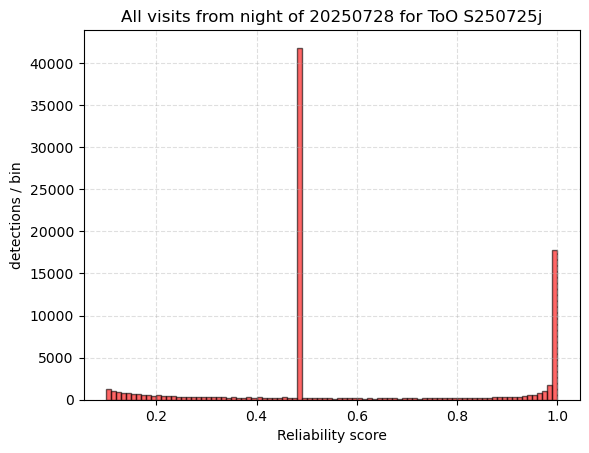

In [466]:
plt.hist(df_max["score"],bins=np.arange(0.1,1.01,step=0.01),
         histtype="barstacked",color="red",alpha=0.6,edgecolor='black')
plt.ylabel("detections / bin")
plt.xlabel("Reliability score")
plt.grid(ls="--",alpha=0.4)
plt.title("All visits from night of 20250728 for ToO S250725j".format(visit))
plt.show()

In [489]:
len(df_max[df_max["score"]>0.1])/len(df_max)

0.1962196182295461

In [469]:
decile=[]
for k in np.arange(0,1,step=0.001):
    decile.append(len(np.where(df_max["score"]>k)[0]))

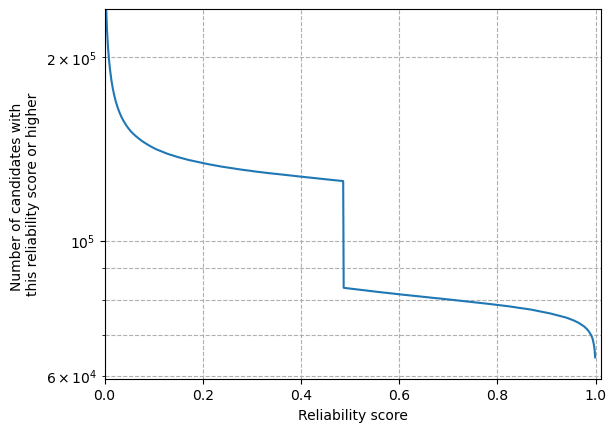

In [486]:
fig,ax = plt.subplots()
ax.semilogy()
ax.plot(np.arange(0,1,step=0.001),decile)
ax.grid(ls="--",which="both")
ax.set_ylabel("Number of candidates with \nthis reliability score or higher")
ax.set_xlabel("Reliability score")
ax.set_ylim(np.min(decile)-5E3,2.4E5)
ax.set_xlim(0,1.01)
plt.show()

## Break

In [256]:
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source" 

In [257]:
center_ra = 234.755524
center_dec = -36.425993
rad = u.Quantity(.3, u.deg)
cols = ['ra', 'dec', 'pmra',"pmdec"]

In [258]:
coord = SkyCoord(ra=center_ra, dec=center_dec, unit=(u.degree, u.degree), frame='icrs')
r = Gaia.query_object_async(coordinate=coord, height=rad,width=rad, columns=cols)

INFO: Query finished. [astroquery.utils.tap.core]


In [259]:
gaia_table = r.to_pandas()

relRows = []

for __, row in gaia_table.iterrows():
    if not np.isnan(row[["ra","dec","pmra","pmdec"]].values).any():
        relRows.append(row[["ra","dec","pmra","pmdec"]])

In [263]:
display = afwDisplay.Display(frame=0,dpi=200)
display.scale('linear', 'zscale')
display.image(search)

scale=0.001
thisWCS = search.getWcs()
with display.Buffering():
    for myx,myy in zip(tab["base_SdssCentroid_x"],tab["base_SdssCentroid_y"]):
        display.dot("o",myx,myy,ctype='blue',size=20)
    # for record in relRows[::2]:
    #     start = coordToPix(thisWCS,record["ra"],record["dec"])
    #     display.dot("o",start[0],start[1],size=10,ctype="orange")
    #     end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
    #     end1 = coordToPix(thisWCS,record["ra"]+0.1*scale*record["pmra"],record["dec"]+0.1*scale*record["pmdec"])
    #     display.line([start,end], ctype='orange')
    # coordPix = coordToPix(thisWCS,center_ra,center_dec)
    # display.dot("o",coordPix[0],coordPix[1],size=20,ctype="red")

In [264]:
display = afwDisplay.Display(frame=1,dpi=200)
display.scale('asinh', 'zscale')
display.image(temp)

scale=0.001
thisWCS = temp.getWcs()
with display.Buffering():
    # for record in relRows[::2]:
    #     start = coordToPix(thisWCS,record["ra"],record["dec"])
    #     display.dot("o",start[0],start[1],size=10,ctype="orange")
    #     end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
    #     end1 = coordToPix(thisWCS,record["ra"]+0.1*scale*record["pmra"],record["dec"]+0.1*scale*record["pmdec"])
    #     display.line([start,end], ctype='orange')
    coordPix = coordToPix(thisWCS,center_ra,center_dec)
    display.dot("o",coordPix[0],coordPix[1],size=20,ctype="red")

In [265]:
display = afwDisplay.Display(frame=2,dpi=300)
display.setMaskTransparency(100)
display.scale('linear', 'zscale')
display.image(diff)

scale=0.001
thisWCS = diff.getWcs()
with display.Buffering():
    for record in relRows:
        start = coordToPix(thisWCS,record["ra"],record["dec"])
        display.dot("o",start[0],start[1],size=10,ctype="orange")
        end = coordToPix(thisWCS,record["ra"]+scale*record["pmra"],record["dec"]+scale*record["pmdec"])
        end1 = coordToPix(thisWCS,record["ra"]+0.1*scale*record["pmra"],record["dec"]+0.1*scale*record["pmdec"])
        display.line([start,end], ctype='orange')
    coordPix = coordToPix(thisWCS,center_ra,center_dec)
    display.dot("o",coordPix[0],coordPix[1],size=20,ctype="red")